# How to really make profit from arbitrage opportunities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
symbol = "ADABTC"
exchange1 = "binance"
exchange2 = "bittrex"

symbol = "LTCBTC"
exchange1 = "bittrex"
exchange2 = "binance"

In [8]:
def load_csv(symbol, exchange):
    return pd.read_csv("data/"+symbol+"_"+exchange+".csv", parse_dates=True, sep = ";", header = None, names=["date", "bid", "ask"], index_col=0)

In [9]:
pair1 = load_csv(symbol, exchange1)
pair2 = load_csv(symbol, exchange2)
pair1.head()

,bid,ask
date,,
2018-02-12 20:51:51.374639,0.018210,0.018325
2018-02-12 20:52:49.143429,0.018216,0.018323
2018-02-12 20:53:57.796482,0.018221,0.018306
2018-02-12 20:54:57.986109,0.018221,0.018300
2018-02-12 20:56:06.490455,0.018222,0.018300


In [10]:
pair2.head()

,bid,ask
date,,
2018-02-12 20:51:51.216755,0.018254,0.018281
2018-02-12 20:52:48.858170,0.018241,0.018279
2018-02-12 20:53:57.348891,0.018241,0.018280
2018-02-12 20:54:57.840664,0.018240,0.018270
2018-02-12 20:56:06.343257,0.018234,0.018270


In [11]:
pair1 = pair1.resample("min").mean().ffill()
pair2 = pair2.resample("min").mean().ffill()
pair1.tail()

,bid,ask
date,,
2018-03-02 19:37:00,0.018820,0.01882
2018-03-02 19:38:00,0.018820,0.01882
2018-03-02 19:39:00,0.018807,0.01882
2018-03-02 19:40:00,0.018812,0.01882
2018-03-02 19:41:00,0.018812,0.01882


In [12]:
pair2.tail()

,bid,ask
date,,
2018-03-02 19:37:00,0.018816,0.018854
2018-03-02 19:38:00,0.018830,0.018862
2018-03-02 19:39:00,0.018830,0.018832
2018-03-02 19:40:00,0.018816,0.018831
2018-03-02 19:41:00,0.018816,0.018831


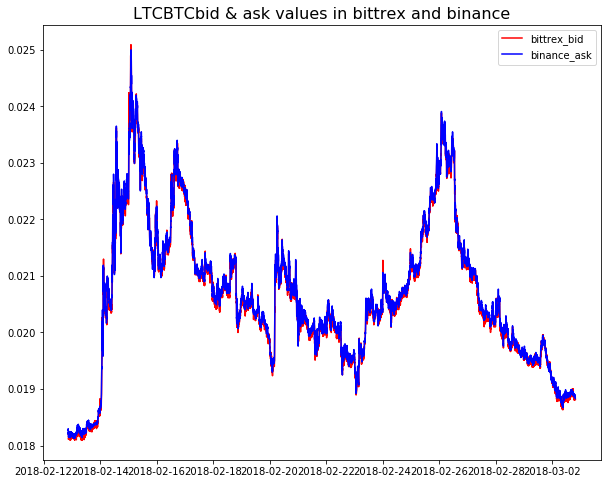

In [38]:
plt.figure(num=1, figsize=(10,8))
plt.title(symbol +"bid & ask values in "+exchange1+" and "+exchange2, fontsize=16)
#plt.plot(((pair1["bid"]+pair1["ask"])/2)[:300], label=exchange1, color="red")
#plt.plot(((pair2["bid"]+pair2["ask"])/2)[:300], label=exchange2, color="blue")
#plt.plot(pair1["bid"][600:900], label=exchange1+"_bid", color="red")
#plt.plot(pair2["ask"][600:900], label=exchange2+"_ask", color="blue")
plt.plot(pair1["bid"], label=exchange1+"_bid", color="red")
plt.plot(pair2["ask"], label=exchange2+"_ask", color="blue")
plt.legend()
plt.show()

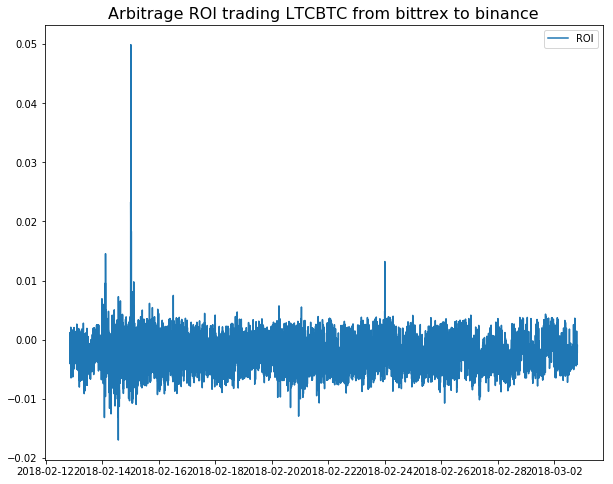

In [18]:
plt.figure(num=1, figsize=(10,8))
plt.title("Arbitrage ROI trading "+symbol+" from "+exchange1+" to "+exchange2, fontsize=16)
plt.plot((pair1["bid"]-pair2["ask"])/pair2["ask"], label="ROI")
plt.legend()
plt.show()

In [19]:
pair1_fee = 0.25/100
pair2_fee = 0.05/100

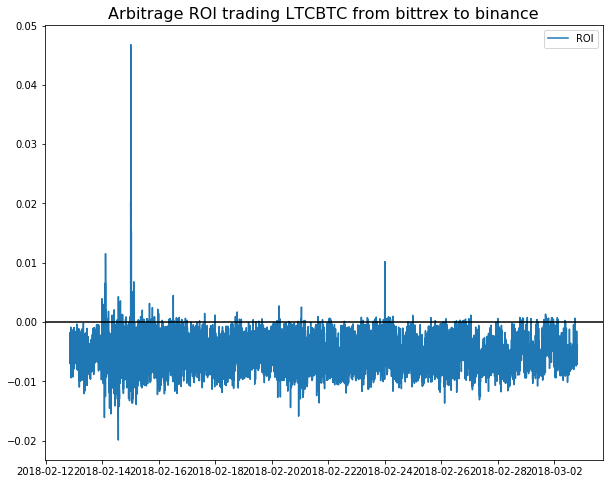

In [36]:
plt.figure(num=1, figsize=(10,8))
plt.title("Arbitrage ROI trading "+symbol+" from "+exchange1+" to "+exchange2, fontsize=16)
diff = pair1["bid"]*(1-pair1_fee)-pair2["ask"]*(1+pair2_fee)
plt.plot(diff/pair2["ask"], label="ROI")
plt.axhline(y=0, color="black")
plt.legend()
plt.show()

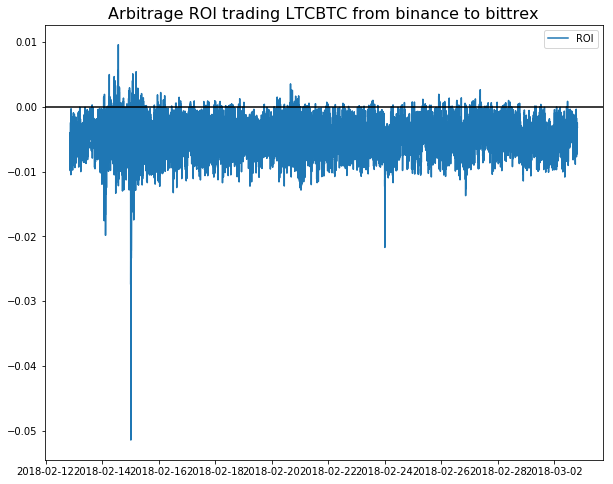

In [37]:
plt.figure(num=1, figsize=(10,8))
plt.title("Arbitrage ROI trading "+symbol+" from "+exchange2+" to "+exchange1, fontsize=16)
diff = pair2["bid"]*(1-pair2_fee)-pair1["ask"]*(1+pair1_fee)
plt.plot(diff/pair1["ask"], label="ROI")
plt.axhline(y=0, color="black")
plt.legend()
plt.show()

In [24]:
def estimate_profit(ask, bid):
    fee = 0.25/100
    return (bid*(1-fee)-ask*(1+fee)) / ask

In [25]:
long_exchange1 = False
long_exchange2 = False
min_percent_profit = 0.3/100
acumulated_profit = 0

for t in pair1.index:
    
    if not long_exchange1 and not long_exchange2:
        
        # Evaluate long pair1 and short pair2
        roi_1_to_2 = estimate_profit(pair1.loc[t]["ask"], pair2.loc[t]["bid"])
        
        if roi_1_to_2 > min_percent_profit:
            long_exchange1 = True
            long_price = pair1.loc[t]["ask"]
            short_price = pair2.loc[t]["bid"]            
            print(t, "Opening")
            print("Buy in", exchange1, "at %.8f"%pair1.loc[t]["ask"])
            print("Sell in", exchange2, "at %.8f"%pair2.loc[t]["bid"])
            print("Estimated ROI: %.4f"%roi_1_to_2)
            
        else:
            
            # Evaluate long pair2 and short pair1
            roi_2_to_1 = estimate_profit(pair2.loc[t]["ask"], pair1.loc[t]["bid"])
            
            if roi_2_to_1 > min_percent_profit:
                long_exchange2 = True
                long_price = pair2.loc[t]["ask"]
                short_price = pair1.loc[t]["bid"]
                print(t, "Opening")
                print("Buy in", exchange2, "at %.8f"%pair2.loc[t]["ask"])
                print("Sell in", exchange1, "at %.8f"%pair1.loc[t]["bid"])
                print("Estimated ROI: %.4f"%roi_2_to_1)
                
    elif long_exchange1:
        
        # Evaluate close: short pair1 and long pair2
        if pair1.loc[t]["bid"]>pair2.loc[t]["ask"]:
            long_exchange1 = False
            btc_profit = (pair1.loc[t]["bid"]*(1-pair1_fee) - long_price*(1+pair2_fee)) + (short_price*(1-pair2_fee) - pair2.loc[t]["ask"]*(1+pair1_fee))
            acumulated_profit += btc_profit
            print(t, "Closing")
            print("Sell in", exchange1, "at %.8f"%pair1.loc[t]["bid"])
            print("Buy in", exchange2, "at %.8f"%pair2.loc[t]["ask"])
            print("Profit: %.8f"%(btc_profit)+" BTC")
            
            
    elif long_exchange2:
        
        # Evaluate close: short pair2 and long pair1
        if pair2.loc[t]["bid"]>pair1.loc[t]["ask"]:
            long_exchange2 = False
            btc_profit = (pair2.loc[t]["bid"]*(1-pair2_fee) - long_price*(1+pair1_fee)) + (short_price*(1-pair2_fee) - pair1.loc[t]["ask"]*(1+pair1_fee))
            acumulated_profit += btc_profit
            print(t, "Closing")
            print("Sell in", exchange2, "at %.8f"%pair2.loc[t]["bid"])
            print("Buy in", exchange1, "at %.8f"%pair1.loc[t]["ask"])
            print("Profit: %.8f"%(btc_profit)+" BTC")

print("Acumulated proifit: %.8f"%acumulated_profit)

2018-02-14 02:49:00 Opening
Buy in binance at 0.02079939
Sell in bittrex at 0.02099901
Estimated ROI: 0.0046
2018-02-14 02:54:00 Closing
Sell in binance at 0.02090500
Buy in bittrex at 0.02087857
Profit: 0.00010090 BTC
2018-02-14 02:58:00 Opening
Buy in binance at 0.02099293
Sell in bittrex at 0.02129846
Estimated ROI: 0.0095
2018-02-14 03:22:00 Closing
Sell in binance at 0.02075200
Buy in bittrex at 0.02074926
Profit: 0.00018289 BTC
2018-02-14 13:41:00 Opening
Buy in bittrex at 0.02277919
Sell in binance at 0.02296700
Estimated ROI: 0.0032
2018-02-14 13:53:00 Closing
Sell in bittrex at 0.02361990
Buy in binance at 0.02344900
Profit: 0.00021816 BTC
2018-02-15 00:19:00 Opening
Buy in binance at 0.02276253
Sell in bittrex at 0.02300355
Estimated ROI: 0.0056
2018-02-15 01:00:00 Closing
Sell in binance at 0.02357800
Buy in bittrex at 0.02357639
Profit: 0.00010350 BTC
2018-02-15 02:03:00 Opening
Buy in binance at 0.02469990
Sell in bittrex at 0.02489901
Estimated ROI: 0.0030
2018-02-15 02:0

Let's say our initial capital is:

Binance:

    1 LTC

    0.03 BTC
    
Bittrex:

    1 LTC

    0.03 BTC

Let's give to LTC a mean value in BTC (0.0206 BTC) over this time, to compute an estimated ROI of this investment without considering LTC cotization changes.
So, our initial capital was:

Binance: 0.0206 BTC + 0.03 BTC = 0.0506 BTC

Bittrex: 0.0206 BTC + 0.03 BTC = 0.0506 BTC

Total initial: 0.1012

Total final: 0.1012 + 0.00126208 = 0.10246208

ROI: 0.10246 / 0.1012 - 1 = 1.2%

This is in one month, take the calculations to think about a year.

In [26]:
exchange1_initial = 0.0206+0.03
print(exchange2, "0.0206 BTC + 0.03 BTC =", exchange1_initial)

binance 0.0206 BTC + 0.03 BTC = 0.0506


In [27]:
exchange2_initial = 0.0206+0.03
print(exchange1, "0.0206 BTC + 0.03 BTC =", exchange2_initial)

bittrex 0.0206 BTC + 0.03 BTC = 0.0506


In [28]:
total_initial = exchange1_initial + exchange2_initial
print("Total initial:", total_initial)

Total initial: 0.1012


In [29]:
total_final = total_initial+acumulated_profit
print("Total final:", total_final)

Total final: 0.1024620835035682


In [247]:
print("ROI:", (total_final / total_initial - 1)*100, "%")

ROI: 1.2471180865298415 %


In [ ]:
def get_prices(pair1, pair2, t, backtesting=False):
    if backtesting:
        t+=1
        pair1_buy=pair1.loc[pair1.index[t]]["ask"]
        pair1_sell=pair1.loc[pair1.index[t]]["bid"]
        pair2_buy=pair2.loc[pair1.index[t]]["ask"]
        pair2_sell=pair2.loc[pair1.index[t]]["bid"]
    else:
        book1 = client1.fetch_order_book(symbol)
        pair1_buy=book["ask"][0][0]
        pair1_sell=book["bid"][0][0]
        
        book2 = client2.fetch_order_book(symbol)
        pair2_buy=book["ask"][0][0]
        pair2_sell=book["bid"][0][0]

In [299]:
class Pricing(object):
    
    """Pricing class: connects to exchanges or read data from databases. Returns bid/ask values.
    It should be initialized with:
    symbol: pair string, for example: "LTC/BTC"
    exchanges: list of exchanges, for example: ["binance", "bittrex"]
    fees: dictionary with exchange fees, for example: {"binance":0.0005, "bittrex:0.0025}
    backtesting: bool that indicates whether to read data from database or to request data from exchanges in order to perform paper trading.
    """
    
    def __init__(self, symbol, exchanges, fees, min_percent_profit, backtesting=True):        
        self.symbol = symbol
        self.exchanges = exchanges
        self.fees = fees
        self.min_percent_profit = min_percent_profit
        self.backtesting = backtesting
        self.clients = dict()
        if backtesting:
            self.load_csv()
        else:
            self.connect()
        self.time_index = 0
            
    def load_csv(self):
        for i, exchange in enumerate(self.exchanges):
            data = pd.read_csv("data/"+self.symbol.replace("/", "")+"_"+self.exchanges[i]+".csv",
                               parse_dates=True, sep = ";", header = None,
                               names=["date", "bid", "ask"], index_col=0)
            self.clients[exchange] = data.resample("min").mean().ffill()
    
    def connect(self):        
        for exchange in self.exchanges:
            exec("client=ccxt.%s()"%(exchange.lower()))
            self.clients[exchange] = client
        
    def get_prices(self, long_exchange, short_exchange):
        if backtesting:
            time = self.clients[long_exchange].index[self.time_index]
            long_price = self.clients[long_exchange].loc[time]["ask"]
            short_price = self.clients[short_exchange].loc[time]["bid"]
            self.time_index += 1
        else:
            long_book = self.clients[long_exchange].fetch_order_book(self.symbol)
            long_price = book["ask"][0][0]
            short_book = self.clients[short_exchange].fetch_order_book(self.symbol)
            short_price = book["bid"][0][0]
        return [long_price, short_price, time]
    
    def get_prices_after_fees(self, prices, positions, exchanges):
        prices_after_fees = []
        for price, position, exchange in zip(prices, positions, exchanges):
            if position=="long":
                prices_after_fees.append(price*(1+self.fees[exchange]))
            elif position=="short":
                prices_after_fees.append(price*(1-self.fees[exchange]))
        return prices_after_fees
                
    def evaluate_arbitrage_open(self):
        
        # evaluate long in exchange 0 and short in exchange 1
        long_p, short_p, time = self.get_prices(long_exchange=self.exchanges[0], short_exchange=self.exchanges[1])
        long_p, short_p = self.get_prices_after_fees(prices=[long_p, short_p], positions=["long", "short"], exchanges=self.exchanges)
        if (long_p - short_p)/long_p > self.min_percent_profit:
            print(time, "Opening")
            print("Long in ", self.exchanges[0], " at: ", long_p)
            print("Short in ", self.exchanges[1], " at: ", short_p)
            return long_p, self.exchanges[0], short_p, self.exchanges[1]
        
        # evaluate long in exchange 1 and short in exchange 0
        long_p, short_p, time = self.get_prices(long_exchange=self.exchanges[1], short_exchange=self.exchanges[0])
        long_p, short_p = self.get_prices_after_fees(prices=[long_p, short_p], positions=["long", "short"], exchanges=self.exchanges[::-1])
        if (long_p - short_p)/long_p > self.min_percent_profit:
            print(time, "Opening")
            print("Long in ", self.exchanges[1], " at: ", long_p)
            print("Short in ", self.exchanges[0], " at: ", short_p)
            return long_p, self.exchanges[1], short_p, self.exchanges[0]
        
        return None, None, None, None
    
    def evaluate_arbitrage_close(self, exchange_to_close_long, exchange_to_close_short):
        
        close_short_p, close_long_p, time = self.get_prices(long_exchange=exchange_to_close_short,
                                                short_exchange=exchange_to_close_long)
        close_short_p, close_long_p = self.get_prices_after_fees(prices=[close_short_p, close_long_p],
                                                                       positions=["long", "short"],
                                                                       exchanges= [exchange_to_close_short,
                                                                                   exchange_to_close_long])
        
        if (close_long_p>close_short_p):
            print(time, "Closing")
            print("Closing long in ", exchange_to_close_long, " at: ", close_long_p)
            print("Closing short in ", exchange_to_close_short, " at: ", close_short_p)
            return close_long_p, close_short_p
        
        return None, None

In [300]:
symbol = "LTC/BTC"
exchanges = ["binance", "bittrex"]
fees = {"binance":0.0005, "bittrex":0.0025}
min_percent_profit = 0.3/100
backtesting=True
prices = Pricing(symbol, exchanges, fees, min_percent_profit, backtesting)

In [305]:
long = {exchange:False for exchange in exchanges}
acumulated_btc = 0
opened_long_price = None
opened_short_price = None
closing_long_price = None
closing_long_price = None
trading = True

while trading:
    
    if all(position == False for position in long.values()):
        try:
            long_price, long_exchange, short_price, short_exchange = prices.evaluate_arbitrage_open()
        except IndexError as e:
            trading = False
        else:
            if long_price is not None:
                long[long_exchange] = True
                opened_long_price = long_price
                opened_short_price = short_price
            
    elif long[exchanges[0]]:
        try:
            close_long_p, close_short_p = prices.evaluate_arbitrage_close(exchange_to_close_long=exchanges[0], 
                                                                          exchange_to_close_short=exchanges[1])
        except IndexError as e:
            trading = False
        else:
            if close_long_p is not None:
                long[exchanges[0]] = False
                closing_long_price = close_long_p
                closing_short_price = close_short_p
                pnl_long = closing_long_price - opened_long_price
                pnl_short = opened_short_price - closing_short_price
                print("PnL at exchange with long position:", pnl_long)
                print("PnL at exchange with short position:", pnl_short)
                acumulated_btc += pnl_long + pnl_short
        
    elif long[exchanges[1]]:
        try:
            close_long_p, close_short_p = prices.evaluate_arbitrage_close(exchange_to_close_long=exchanges[1], 
                                                                          exchange_to_close_short=exchanges[0])
        except IndexError as e:
            trading = False
        else:
            if close_long_p is not None:
                long[exchanges[1]] = False
                closing_long_price = close_long_p
                closing_short_price = close_short_p
                pnl_long = closing_long_price - opened_long_price
                pnl_short = opened_short_price - closing_short_price
                print("PnL at exchange with long position:", pnl_long)
                print("PnL at exchange with short position:", pnl_short)
                acumulated_btc += pnl_long + pnl_short
        
        
print("Acumulated BTC:", acumulated_btc)

2018-02-13 15:34:00 Opening
Long in  binance  at:  0.01835959405234096
Short in  bittrex  at:  0.01821093114593021
2018-02-13 15:35:00 Closing
Closing long in  binance  at:  0.018323833500000004
Closing short in  bittrex  at:  0.018318191275
PnL at exchange with long position: -3.576055234095696e-05
PnL at exchange with short position: -0.00010726012906979096
2018-02-13 15:36:00 Opening
Long in  binance  at:  0.01835085721208445
Short in  bittrex  at:  0.018207497884921736
2018-02-14 01:25:00 Closing
Closing long in  binance  at:  0.019194883625727053
Closing short in  bittrex  at:  0.01916588649246974
PnL at exchange with long position: 0.000844026413642604
PnL at exchange with short position: -0.0009583886075480025
2018-02-14 01:26:00 Opening
Long in  binance  at:  0.019276748210836376
Short in  bittrex  at:  0.01917475165302179
2018-02-14 02:01:00 Closing
Closing long in  binance  at:  0.020119935000000002
Closing short in  bittrex  at:  0.020107593625
PnL at exchange with long posi

2018-02-14 16:06:00 Closing
Closing long in  binance  at:  0.0226206305262726
Closing short in  bittrex  at:  0.022606324874999997
PnL at exchange with long position: -0.0002695029485566408
PnL at exchange with short position: 0.00021303911689650457
2018-02-14 16:07:00 Opening
Long in  binance  at:  0.022639411766513396
Short in  bittrex  at:  0.022488886875
2018-02-14 16:40:00 Closing
Closing long in  binance  at:  0.022285536190941365
Closing short in  bittrex  at:  0.022284388586485602
PnL at exchange with long position: -0.00035387557557203103
PnL at exchange with short position: 0.00020449828851439728
2018-02-14 16:41:00 Opening
Long in  binance  at:  0.022304992567295876
Short in  bittrex  at:  0.022145832151773022
2018-02-14 17:49:00 Closing
Closing long in  binance  at:  0.021986078756240555
Closing short in  bittrex  at:  0.02198106432010059
PnL at exchange with long position: -0.00031891381105532066
PnL at exchange with short position: 0.000164767831672432
2018-02-14 17:50:00

2018-02-15 02:24:00 Closing
Closing long in  bittrex  at:  0.024688274625
Closing short in  binance  at:  0.0246112995
PnL at exchange with long position: -0.0004733567204003447
PnL at exchange with short position: 0.00031922900000000073
2018-02-15 02:26:00 Opening
Long in  bittrex  at:  0.024857572617937657
Short in  binance  at:  0.02452773
2018-02-15 02:29:00 Closing
Closing long in  bittrex  at:  0.02491356
Closing short in  binance  at:  0.024912449999999996
PnL at exchange with long position: 5.5987382062343966e-05
PnL at exchange with short position: -0.00038471999999999465
2018-02-15 02:31:00 Opening
Long in  bittrex  at:  0.02502740302236498
Short in  binance  at:  0.024719666766866013
2018-02-15 02:34:00 Closing
Closing long in  bittrex  at:  0.024685818399161102
Closing short in  binance  at:  0.0246478566288355
PnL at exchange with long position: -0.0003415846232038798
PnL at exchange with short position: 7.181013803051264e-05
2018-02-15 02:36:00 Opening
Long in  bittrex  a

2018-02-15 13:53:00 Closing
Closing long in  bittrex  at:  0.022764565950000003
Closing short in  binance  at:  0.0227603745
PnL at exchange with long position: -0.0004934340499999947
PnL at exchange with short position: 0.00036276045695151846
2018-02-15 13:55:00 Opening
Long in  bittrex  at:  0.022863558922180865
Short in  binance  at:  0.02268865
2018-02-15 13:57:00 Closing
Closing long in  bittrex  at:  0.022643250000000004
Closing short in  binance  at:  0.02263113637748513
PnL at exchange with long position: -0.00022030892218086184
PnL at exchange with short position: 5.7513622514871604e-05
2018-02-15 13:58:00 Opening
Long in  binance  at:  0.022609299
Short in  bittrex  at:  0.02253434582802992
2018-02-15 20:25:00 Closing
Closing long in  binance  at:  0.021377306000000002
Closing short in  bittrex  at:  0.02137119475
PnL at exchange with long position: -0.0012319929999999972
PnL at exchange with short position: 0.0011631510780299205
2018-02-15 20:26:00 Opening
Long in  binance  

2018-02-16 19:43:00 Closing
Closing long in  bittrex  at:  0.0227011449
Closing short in  binance  at:  0.02269134
PnL at exchange with long position: -5.537452499999873e-05
PnL at exchange with short position: -7.851500014973561e-06
2018-02-16 19:45:00 Opening
Long in  bittrex  at:  0.022891734702792547
Short in  binance  at:  0.022672478516059066
2018-02-16 20:06:00 Closing
Closing long in  bittrex  at:  0.022752975
Closing short in  binance  at:  0.022747763034289152
PnL at exchange with long position: -0.0001387597027925451
PnL at exchange with short position: -7.52845182300857e-05
2018-02-16 20:08:00 Opening
Long in  bittrex  at:  0.022892057424999997
Short in  binance  at:  0.022732299268040525
2018-02-16 20:09:00 Closing
Closing long in  bittrex  at:  0.022762108023796846
Closing short in  binance  at:  0.022761374999999997
PnL at exchange with long position: -0.0001299494012031513
PnL at exchange with short position: -2.9075731959472134e-05
2018-02-16 20:11:00 Opening
Long in  

2018-02-18 09:00:00 Closing
Closing long in  binance  at:  0.02092880488271901
Closing short in  bittrex  at:  0.020924641098240812
PnL at exchange with long position: 0.000382970336500095
PnL at exchange with short position: -0.0004534357276800953
2018-02-18 09:01:00 Opening
Long in  binance  at:  0.02095047
Short in  bittrex  at:  0.020827800000000004
2018-02-18 10:23:00 Closing
Closing long in  binance  at:  0.0208525685
Closing short in  bittrex  at:  0.020851899750000003
PnL at exchange with long position: -9.79014999999972e-05
PnL at exchange with short position: -2.4099749999999254e-05
2018-02-18 10:24:00 Opening
Long in  binance  at:  0.020944402127766975
Short in  bittrex  at:  0.020747910225000003
2018-02-18 11:34:00 Closing
Closing long in  binance  at:  0.02076095421981864
Closing short in  bittrex  at:  0.020760531899999997
PnL at exchange with long position: -0.00018344790794833435
PnL at exchange with short position: -1.2621674999994253e-05
2018-02-18 11:35:00 Opening
Lo

2018-02-20 05:31:00 Closing
Closing long in  binance  at:  0.021142953665217585
Closing short in  bittrex  at:  0.021119857975
PnL at exchange with long position: 0.00010644066521758519
PnL at exchange with short position: -0.00028588566462988893
2018-02-20 05:32:00 Opening
Long in  binance  at:  0.021189131372866106
Short in  bittrex  at:  0.020994807305326258
2018-02-20 06:19:00 Closing
Closing long in  binance  at:  0.0220199845
Closing short in  bittrex  at:  0.022011153382358477
PnL at exchange with long position: 0.0008308531271338931
PnL at exchange with short position: -0.0010163460770322187
2018-02-20 06:20:00 Opening
Long in  binance  at:  0.022043016
Short in  bittrex  at:  0.021867015450000003
2018-02-20 06:21:00 Closing
Closing long in  binance  at:  0.0220199845
Closing short in  bittrex  at:  0.022011153382358477
PnL at exchange with long position: -2.3031499999999483e-05
PnL at exchange with short position: -0.0001441379323584742
2018-02-20 06:22:00 Opening
Long in  bin

2018-02-21 03:08:00 Closing
Closing long in  binance  at:  0.020419785000000003
Closing short in  bittrex  at:  0.020418428774999997
PnL at exchange with long position: 0.0001882894784471928
PnL at exchange with short position: -0.00040558627499999444
2018-02-21 03:09:00 Opening
Long in  binance  at:  0.020455501963634482
Short in  bittrex  at:  0.020305938705504848
2018-02-21 04:32:00 Closing
Closing long in  binance  at:  0.02023011069127276
Closing short in  bittrex  at:  0.020221317225
PnL at exchange with long position: -0.00022539127236172185
PnL at exchange with short position: 8.462148050484772e-05
2018-02-21 04:33:00 Opening
Long in  binance  at:  0.020255122499999997
Short in  bittrex  at:  0.02009816755471445
2018-02-21 06:06:00 Closing
Closing long in  binance  at:  0.0202648625
Closing short in  bittrex  at:  0.020260795675
PnL at exchange with long position: 9.740000000004606e-06
PnL at exchange with short position: -0.00016262812028554688
2018-02-21 06:07:00 Opening
Long

2018-02-23 14:11:00 Closing
Closing long in  binance  at:  0.020677656
Closing short in  bittrex  at:  0.020676523868088627
PnL at exchange with long position: 3.83415000000005e-05
PnL at exchange with short position: -0.00022728390135649465
2018-02-23 14:12:00 Opening
Long in  binance  at:  0.020719289110595757
Short in  bittrex  at:  0.02057937445636221
2018-02-23 14:33:00 Closing
Closing long in  binance  at:  0.020673658
Closing short in  bittrex  at:  0.0206715099
PnL at exchange with long position: -4.5631110595755614e-05
PnL at exchange with short position: -9.213544363778983e-05
2018-02-23 14:34:00 Opening
Long in  binance  at:  0.0207013455
Short in  bittrex  at:  0.02051862153698515
2018-02-23 14:59:00 Closing
Closing long in  binance  at:  0.02055830414168509
Closing short in  bittrex  at:  0.020551334205351504
PnL at exchange with long position: -0.000143041358314909
PnL at exchange with short position: -3.271266836635256e-05
2018-02-23 15:00:00 Opening
Long in  binance  at

2018-02-25 14:16:00 Closing
Closing long in  binance  at:  0.021785359349988136
Closing short in  bittrex  at:  0.021779312500000002
PnL at exchange with long position: -0.00031468515001185915
PnL at exchange with short position: 0.00014957521493416323
2018-02-25 14:17:00 Opening
Long in  binance  at:  0.021839914499999998
Short in  bittrex  at:  0.021680712375
2018-02-25 15:32:00 Closing
Closing long in  binance  at:  0.022110939
Closing short in  bittrex  at:  0.022105225249999996
PnL at exchange with long position: 0.0002710245000000014
PnL at exchange with short position: -0.0004245128749999945
2018-02-25 15:33:00 Opening
Long in  binance  at:  0.022162898357777763
Short in  bittrex  at:  0.021969119610600094
2018-02-25 21:55:00 Closing
Closing long in  binance  at:  0.02300938809728896
Closing short in  bittrex  at:  0.02300847775
PnL at exchange with long position: 0.0008464897395111977
PnL at exchange with short position: -0.0010393581393999055
2018-02-25 21:56:00 Opening
Long i

2018-02-26 20:15:00 Closing
Closing long in  binance  at:  0.02138278653931702
Closing short in  bittrex  at:  0.02137324063367669
PnL at exchange with long position: -0.00026184266841968937
PnL at exchange with short position: 9.742816632330939e-05
2018-02-26 20:16:00 Opening
Long in  binance  at:  0.021430067315651665
Short in  bittrex  at:  0.021225184050000002
2018-02-26 20:18:00 Closing
Closing long in  binance  at:  0.021405009158580707
Closing short in  bittrex  at:  0.021393059275
PnL at exchange with long position: -2.5058157070958348e-05
PnL at exchange with short position: -0.00016787522499999916
2018-02-26 20:19:00 Opening
Long in  binance  at:  0.021430633683447047
Short in  bittrex  at:  0.021286350750000006
2018-02-26 21:19:00 Closing
Closing long in  binance  at:  0.021589608469154604
Closing short in  bittrex  at:  0.021583835024999998
PnL at exchange with long position: 0.00015897478570755727
PnL at exchange with short position: -0.00029748427499999217
2018-02-26 21:2

2018-02-27 23:34:00 Closing
Closing long in  binance  at:  0.020265021573885933
Closing short in  bittrex  at:  0.020250499999999998
PnL at exchange with long position: 6.492657388593517e-05
PnL at exchange with short position: -0.00017679004999999678
2018-02-27 23:35:00 Opening
Long in  binance  at:  0.020286138
Short in  bittrex  at:  0.02012955
2018-02-27 23:36:00 Closing
Closing long in  binance  at:  0.020257866000000003
Closing short in  bittrex  at:  0.020250489975
PnL at exchange with long position: -2.8271999999995856e-05
PnL at exchange with short position: -0.00012093997500000134
2018-02-27 23:37:00 Opening
Long in  binance  at:  0.020283225382345185
Short in  bittrex  at:  0.02012955
2018-02-28 04:14:00 Closing
Closing long in  binance  at:  0.02010994
Closing short in  bittrex  at:  0.020106305674335745
PnL at exchange with long position: -0.00017328538234518548
PnL at exchange with short position: 2.3244325664254634e-05
2018-02-28 04:15:00 Opening
Long in  binance  at:  0